In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
!pip install catboost lightgbm xgboost

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from pandas.plotting import scatter_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

In [4]:
train = pd.read_csv('../input/spaceship-titanic/train.csv')
test = pd.read_csv('../input/spaceship-titanic/test.csv')

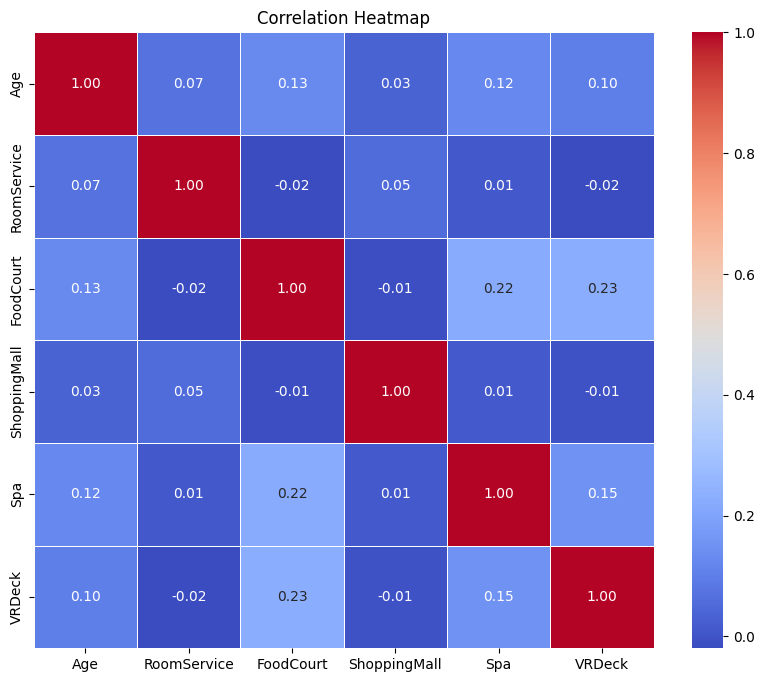

In [5]:
#The matrix provides understanding of how one feature affects the other features i.e. direct or indirect
correlation_matrix = train.select_dtypes(include=['float64', 'int']).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [6]:
#Column PassengerId is split into two different columns. For exploring futher for any feature importance.
train[['Group', 'Person']] = train['PassengerId'].str.split('_', expand=True)

#We tend to remove the existing column to reduce complexity of the data
train.drop('PassengerId', axis=1, inplace=True)

In [7]:
#Function gives the datatype of the values in the column
train['Group'].dtypes

dtype('O')

In [8]:
train['Person'].unique()

array(['01', '02', '03', '04', '05', '06', '07', '08'], dtype=object)

In [9]:
#Similarly, I split the Cabin column into Deck, Num, Side 
train[['Deck', 'Num', 'Side']] = train['Cabin'].str.split('/', expand=True)

train.drop('Cabin', axis=1, inplace=True)

In [10]:
train[['fName', 'lName']] = train['Name'].str.split(' ', expand=True)

train.drop('Name', axis=1, inplace=True)

In [11]:
#To add an additional feature; I create a new colum called 'Expense' to store the sum of all the expenditures
train['expense'] = train[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)

In [12]:
#Function to preprocess data
def process(df):
    df[['Group', 'Person']] = df['PassengerId'].str.split('_', expand=True)
    df.drop('PassengerId', axis=1, inplace=True)
    
    df[['Deck', 'Num', 'Side']] = df['Cabin'].str.split('/', expand=True)
    df.drop('Cabin', axis=1, inplace=True)
    
    df[['fName', 'lName']] = df['Name'].str.split(' ', expand=True)
    df.drop('Name', axis=1, inplace=True)
    
    df['expense'] = df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)

In [13]:
#Data Preprocessing for the test dataset
process(test)

In [14]:
#I have split the columns into 4 categories for Numerical values(int, float), Categorical values(obj, str), target and name
#Name is a separate column as I will not be working on it. Probably dropping it later.
numeric_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'expense']
categorical_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Group', 'Person', 'Num', 'Deck', 'Side']
name_col = ['fName', 'lName']
trans_col = ['Transported']

In [15]:
#For numeric values, I tend to take the Mean of the data column (Not the best approach)
imputer = SimpleImputer(strategy='mean')
train[numeric_cols] = imputer.fit_transform(train[numeric_cols])

In [16]:
#For categorical columns, I tend to use the strategy 'most_frequent' i.e Mode
imputer = SimpleImputer(strategy='most_frequent')
train[categorical_cols] = imputer.fit_transform(train[categorical_cols])

In [17]:
#Updating the expense column after handling missing values
train['expense'] = train[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)

In [18]:
#Just filling the missing values for 'Name' as Unknown
train['fName'].fillna('Unknown', inplace=True)
train['lName'].fillna('Unknown', inplace=True)

/tmp/ipykernel_18/1354947874.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['fName'].fillna('Unknown', inplace=True)
/tmp/ipykernel_18/1354947874.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

In [19]:
#Function to clean the dataset
def clean(df):
    df[numeric_cols] = imputer.fit_transform(df[numeric_cols])
    
    df[categorical_cols] = imputer.fit_transform(df[categorical_cols])
    
    df['expense'] = df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)
    
    df['fName'].fillna('Unknown', inplace=True)
    df['lName'].fillna('Unknown', inplace=True)

In [20]:
#Cleaning the test dataset
clean(test)

/tmp/ipykernel_18/3822005947.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['fName'].fillna('Unknown', inplace=True)
/tmp/ipykernel_18/3822005947.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'd

In [21]:
test.isnull().sum()

HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Group           0
Person          0
Deck            0
Num             0
Side            0
fName           0
lName           0
expense         0
dtype: int64

In [22]:
#Performing One Hot Encoding by creating dummy variables for unique values from the column. The binary values reduce complexity in data
cols = ['Deck']

train = pd.get_dummies(train, columns=cols)

In [23]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

train.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Group,Person,Num,Side,fName,lName,expense,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,0001,01,0,P,Maham,Ofracculy,0.0,False,True,False,False,False,False,False,False
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,0002,01,0,S,Juanna,Vines,736.0,False,False,False,False,False,True,False,False
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,0003,01,0,S,Altark,Susent,10383.0,True,False,False,False,False,False,False,False
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,0003,02,0,S,Solam,Susent,5176.0,True,False,False,False,False,False,False,False
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,0004,01,1,S,Willy,Santantines,1091.0,False,False,False,False,False,True,False,False


In [24]:
#Performing label encoding to categorical columns
le_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Side', 'Num']

label_encoder = LabelEncoder()

for col in le_cols:
    train[col] = label_encoder.fit_transform(train[col].astype(str))

In [25]:
#Dropping the columns that dont have significance in data modelling
d_cols = ['Group', 'Person', 'fName', 'lName']

train.drop(d_cols, axis=1, inplace=True)

In [26]:
#Function for feature engineering (Categorical Features)
def fe_eng(df):
    cols = ['Deck']
    df = pd.get_dummies(df, columns=cols)
    
    le_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Side', 'Num']
    label_encoder = LabelEncoder()

    for col in le_cols:
        df[col] = label_encoder.fit_transform(df[col].astype(str))
        
    return df

In [27]:
#Feature Engineering the test dataset
test = fe_eng(test)

In [28]:
#Function to scale data (Numeric Columns)
def scale(df):
    numeric_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'expense']
    scaler = StandardScaler()
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
    return df

train = scale(train)
test = scale(test)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

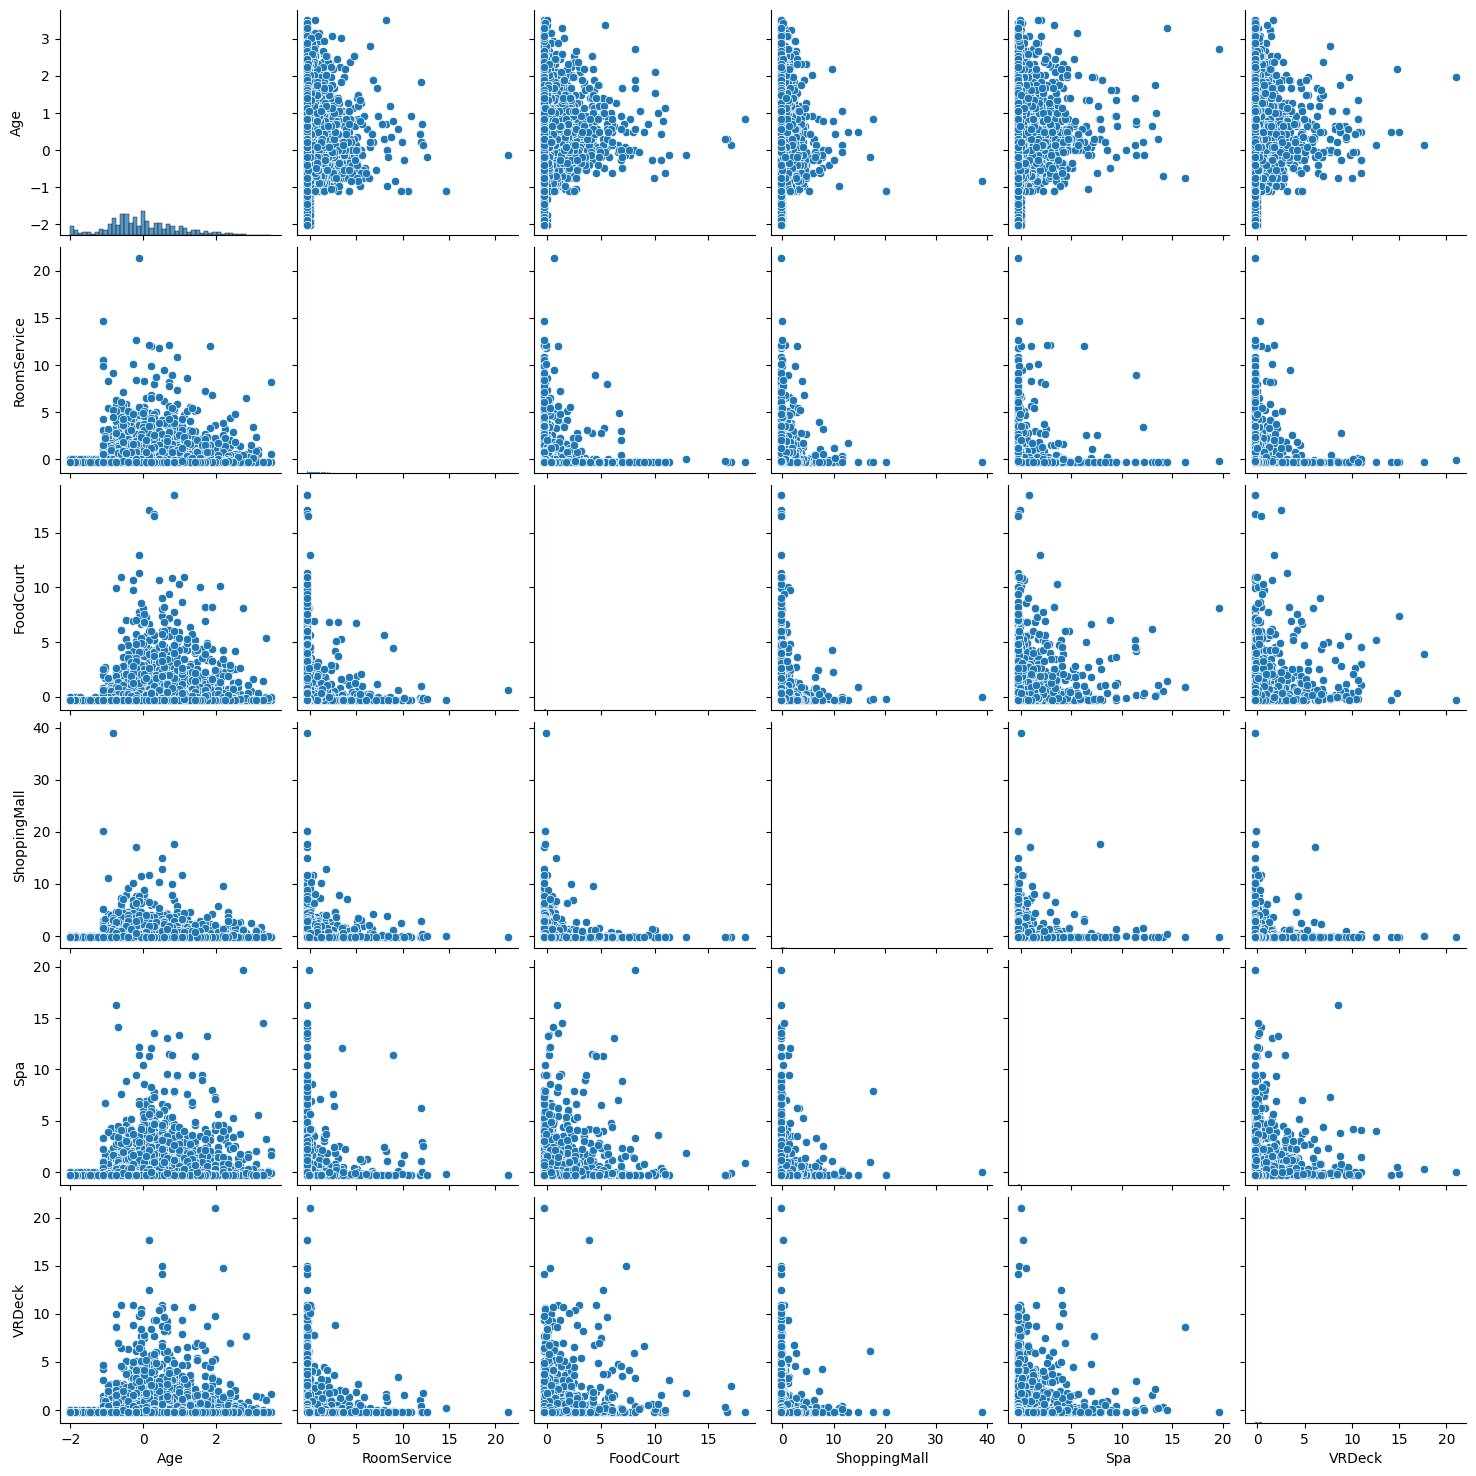

In [29]:
numeric_columns = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

sns.pairplot(train[numeric_columns])
plt.show()

In [30]:
#Splitting train data into train and test set with Train (70%) and Test(30%)
X = train.drop("Transported", axis=1).values
y = train["Transported"].values

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [31]:
#Efficiently evaluates multiple machine learning classifiers using cross-validation 
#Provides a comparison of their performance based on accuracy
models = []
models.append(("Logistic Regression", LogisticRegression()))
models.append(('Decision Tree', DecisionTreeClassifier()))
models.append(('Random Forest', RandomForestClassifier()))
models.append(('SVM', SVC()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CatBoost', CatBoostClassifier()))
models.append(('LightGBM', lgb.LGBMClassifier()))
models.append(('AdaBoost', AdaBoostClassifier()))
models.append(('XGBoost', XGBClassifier()))
models.append(('LinearSVC', LinearSVC()))
models.append(('GradientBoosting', GradientBoostingClassifier()))
models.append(('GaussianNB', GaussianNB()))

results = []
names = []

for name, model in models:
    kfold = StratifiedKFold(n_splits=4, random_state=1, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print("cv_results", cv_results)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    print()

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

cv_results [0.8022339  0.79947403 0.79815911 0.78829717]
Logistic Regression: 0.797041 (0.005258)

cv_results [0.75295664 0.76134122 0.73241289 0.72781065]
Decision Tree: 0.743630 (0.013935)

cv_results [0.81274639 0.8086785  0.79684418 0.79552926]
Random Forest: 0.803450 (0.007418)

cv_results [0.53679369 0.53122945 0.51676529 0.53714661]
SVM: 0.530484 (0.008261)

cv_results [0.61366623 0.61012492 0.59763314 0.58645628]
KNN: 0.601970 (0.010756)

Learning rate set to 0.019699
0:	learn: 0.6820509	total: 55.6ms	remaining: 55.5s
1:	learn: 0.6720044	total: 58ms	remaining: 29s
2:	learn: 0.6633998	total: 60.5ms	remaining: 20.1s
3:	learn: 0.6563410	total: 62.8ms	remaining: 15.6s
4:	learn: 0.6479012	total: 65.1ms	remaining: 13s
5:	learn: 0.6403517	total: 67.5ms	remaining: 11.2s
6:	learn: 0.6335485	total: 69.7ms	remaining: 9.89s
7:	learn: 0.6255110	total: 72ms	remaining: 8.93s
8:	learn: 0.6199775	total: 74.3ms	remaining: 8.18s
9:	learn: 0.6139387	total: 76.6ms	remaining: 7.58s
10:	learn: 0.6078

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py", line 113, in _check_targets
    unique_values = np.union1d(y_true, y_pred)
  File "/opt/conda/lib/python3.10/site-packages/numpy/lib/arraysetops.py", line 932, in union1d
    return unique(np.concatenate((ar1, ar2), axis=None))
  File "/opt/conda/lib/python3.10/site-packages/numpy/lib/arraysetops.py", line 274, in unique
    ret = _unique1d(ar, return_index, return_inverse, return_counts,
  File "/opt/conda/lib/python3.10/site-packages/numpy/lib/arraysetops.py", line 336, in _unique1d
    ar.sort()
TypeError: '<' not supported between instances of 'str' and 'bool'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):


5:	learn: 0.6449979	total: 16ms	remaining: 2.64s
6:	learn: 0.6383247	total: 18.7ms	remaining: 2.66s
7:	learn: 0.6306990	total: 21ms	remaining: 2.61s
8:	learn: 0.6252628	total: 23.3ms	remaining: 2.56s
9:	learn: 0.6197847	total: 25.5ms	remaining: 2.52s
10:	learn: 0.6124336	total: 27.6ms	remaining: 2.48s
11:	learn: 0.6060571	total: 30.1ms	remaining: 2.48s
12:	learn: 0.5987293	total: 33ms	remaining: 2.5s
13:	learn: 0.5936919	total: 35.5ms	remaining: 2.5s
14:	learn: 0.5885527	total: 37.9ms	remaining: 2.49s
15:	learn: 0.5832685	total: 40.2ms	remaining: 2.47s
16:	learn: 0.5768550	total: 42.5ms	remaining: 2.46s
17:	learn: 0.5718833	total: 44.8ms	remaining: 2.45s
18:	learn: 0.5668677	total: 47.1ms	remaining: 2.43s
19:	learn: 0.5622153	total: 49.4ms	remaining: 2.42s
20:	learn: 0.5587064	total: 51.8ms	remaining: 2.41s
21:	learn: 0.5549011	total: 54ms	remaining: 2.4s
22:	learn: 0.5515002	total: 56.3ms	remaining: 2.39s
23:	learn: 0.5477066	total: 58.7ms	remaining: 2.38s
24:	learn: 0.5440307	total: 

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py", line 113, in _check_targets
    unique_values = np.union1d(y_true, y_pred)
  File "/opt/conda/lib/python3.10/site-packages/numpy/lib/arraysetops.py", line 932, in union1d
    return unique(np.concatenate((ar1, ar2), axis=None))
  File "/opt/conda/lib/python3.10/site-packages/numpy/lib/arraysetops.py", line 274, in unique
    ret = _unique1d(ar, return_index, return_inverse, return_counts,
  File "/opt/conda/lib/python3.10/site-packages/numpy/lib/arraysetops.py", line 336, in _unique1d
    ar.sort()
TypeError: '<' not supported between instances of 'str' and 'bool'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):


1:	learn: 0.6756447	total: 5.86ms	remaining: 2.93s
2:	learn: 0.6670616	total: 9.5ms	remaining: 3.16s
3:	learn: 0.6583702	total: 11.9ms	remaining: 2.95s
4:	learn: 0.6504669	total: 14.1ms	remaining: 2.8s
5:	learn: 0.6427567	total: 16.3ms	remaining: 2.69s
6:	learn: 0.6362825	total: 18.4ms	remaining: 2.61s
7:	learn: 0.6287149	total: 20.8ms	remaining: 2.58s
8:	learn: 0.6230304	total: 23.1ms	remaining: 2.54s
9:	learn: 0.6178264	total: 25.4ms	remaining: 2.51s
10:	learn: 0.6103986	total: 27.7ms	remaining: 2.49s
11:	learn: 0.6043284	total: 30.2ms	remaining: 2.49s
12:	learn: 0.5965593	total: 32.4ms	remaining: 2.46s
13:	learn: 0.5921394	total: 34.6ms	remaining: 2.43s
14:	learn: 0.5865388	total: 36.8ms	remaining: 2.42s
15:	learn: 0.5819002	total: 39ms	remaining: 2.4s
16:	learn: 0.5781842	total: 41.2ms	remaining: 2.38s
17:	learn: 0.5737068	total: 43.5ms	remaining: 2.37s
18:	learn: 0.5698677	total: 45.7ms	remaining: 2.36s
19:	learn: 0.5643307	total: 47.9ms	remaining: 2.35s
20:	learn: 0.5601028	total

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py", line 113, in _check_targets
    unique_values = np.union1d(y_true, y_pred)
  File "/opt/conda/lib/python3.10/site-packages/numpy/lib/arraysetops.py", line 932, in union1d
    return unique(np.concatenate((ar1, ar2), axis=None))
  File "/opt/conda/lib/python3.10/site-packages/numpy/lib/arraysetops.py", line 274, in unique
    ret = _unique1d(ar, return_index, return_inverse, return_counts,
  File "/opt/conda/lib/python3.10/site-packages/numpy/lib/arraysetops.py", line 336, in _unique1d
    ar.sort()
TypeError: '<' not supported between instances of 'str' and 'bool'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):


29:	learn: 0.5281232	total: 69.1ms	remaining: 2.23s
30:	learn: 0.5243942	total: 71.9ms	remaining: 2.25s
31:	learn: 0.5213586	total: 73.9ms	remaining: 2.23s
32:	learn: 0.5191442	total: 77.9ms	remaining: 2.28s
33:	learn: 0.5169425	total: 82ms	remaining: 2.33s
34:	learn: 0.5139343	total: 84.4ms	remaining: 2.33s
35:	learn: 0.5115041	total: 87.1ms	remaining: 2.33s
36:	learn: 0.5093442	total: 89.7ms	remaining: 2.33s
37:	learn: 0.5063666	total: 92.2ms	remaining: 2.33s
38:	learn: 0.5042340	total: 94.6ms	remaining: 2.33s
39:	learn: 0.5023760	total: 97.1ms	remaining: 2.33s
40:	learn: 0.5003712	total: 99.4ms	remaining: 2.32s
41:	learn: 0.4984376	total: 102ms	remaining: 2.32s
42:	learn: 0.4965480	total: 104ms	remaining: 2.32s
43:	learn: 0.4949885	total: 107ms	remaining: 2.31s
44:	learn: 0.4925430	total: 109ms	remaining: 2.31s
45:	learn: 0.4910582	total: 111ms	remaining: 2.3s
46:	learn: 0.4888543	total: 113ms	remaining: 2.3s
47:	learn: 0.4874025	total: 115ms	remaining: 2.29s
48:	learn: 0.4858953	to

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py", line 113, in _check_targets
    unique_values = np.union1d(y_true, y_pred)
  File "/opt/conda/lib/python3.10/site-packages/numpy/lib/arraysetops.py", line 932, in union1d
    return unique(np.concatenate((ar1, ar2), axis=None))
  File "/opt/conda/lib/python3.10/site-packages/numpy/lib/arraysetops.py", line 274, in unique
    ret = _unique1d(ar, return_index, return_inverse, return_counts,
  File "/opt/conda/lib/python3.10/site-packages/numpy/lib/arraysetops.py", line 336, in _unique1d
    ar.sort()
TypeError: '<' not supported between instances of 'str' and 'bool'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1890
[LightGBM] [Info] Number of data points in the train set: 4563, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502739 -> initscore=0.010958
[LightGBM] [Info] Start training from score 0.010958
[LightGBM] [Info] Number of positive: 2294, number of negative: 2270
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1889
[LightGBM] [Info] Number of data points in the train set: 4564, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502629 -> initscore=0.010517
[LightGBM] [Info] Start training from score 0.010517
[LightGBM] [Info] Number of

/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


cv_results [0.68659658 0.72583826 0.70545694 0.65088757]
LinearSVC: 0.692195 (0.027593)

cv_results [0.81340342 0.80013149 0.80144642 0.80210388]
GradientBoosting: 0.804271 (0.005320)

cv_results [0.6609724  0.72320842 0.70282709 0.71531887]
GaussianNB: 0.700582 (0.023995)



In [32]:
#Summary of the best model among all the models
best_model_idx = np.argmax([result.mean() for result in results])
best_model_name = names[best_model_idx]
best_model_accuracy = results[best_model_idx].mean()

print(f"The best model is {best_model_name} with an accuracy of {best_model_accuracy:.4f}.")

The best model is CatBoost with an accuracy of nan.


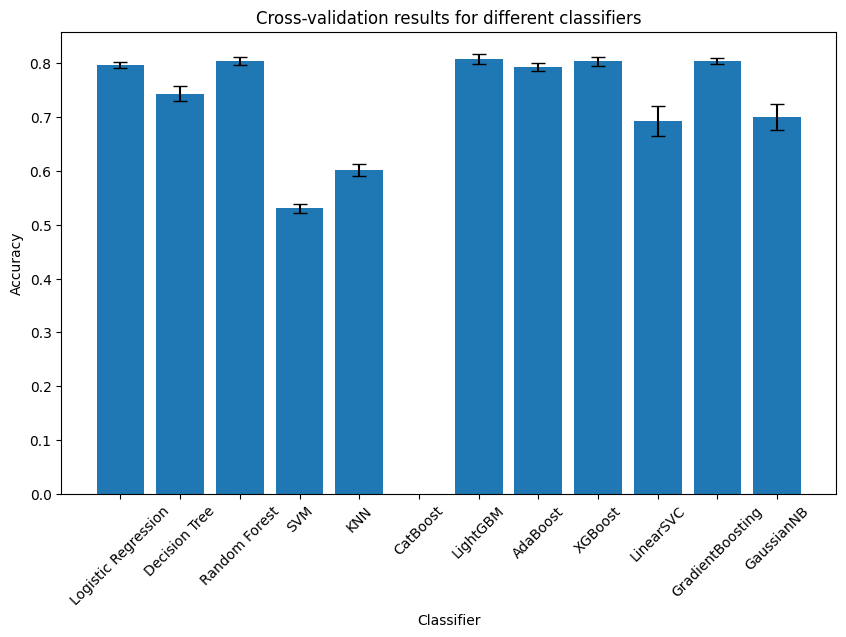

In [33]:
#Bar Plot to analyse the results
plt.figure(figsize=(10, 6))
plt.bar(names, [result.mean() for result in results], yerr=[result.std() for result in results], capsize=5)
plt.xticks(rotation=45)
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.title('Cross-validation results for different classifiers')
plt.show()


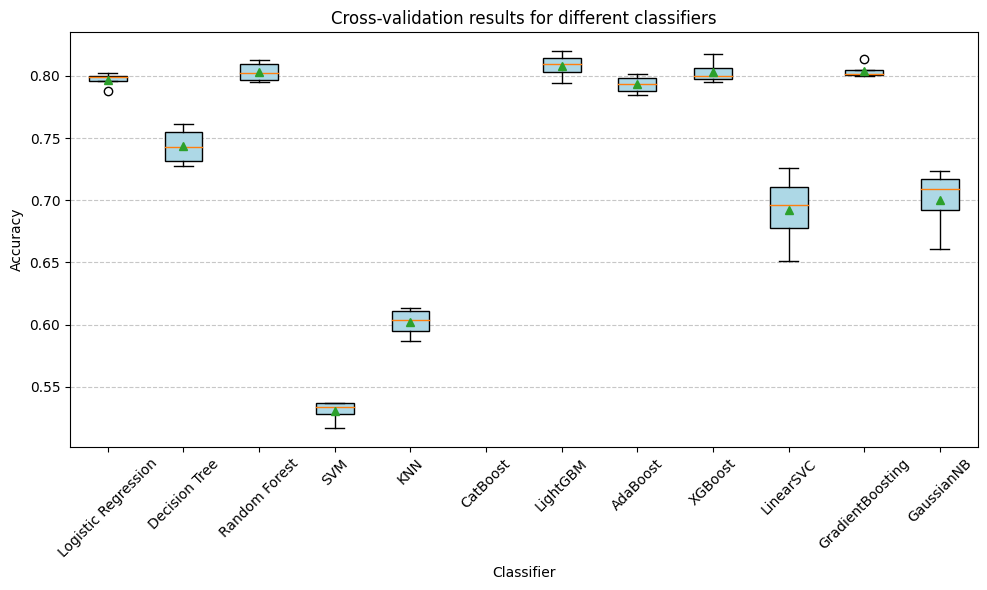

In [34]:
#Box Plot to understand the results to identify outliers
plt.figure(figsize=(10, 6))
plt.boxplot(results, labels=names, showmeans=True, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.xticks(rotation=45)
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.title('Cross-validation results for different classifiers')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  
plt.show()

In [35]:
#verifying the total samples in the dataset
print("Number of samples in X_test:", len(X_test))
print("Number of samples in y_test:", len(y_test))

Number of samples in X_test: 2608
Number of samples in y_test: 2608


In [36]:
'''model  = CatBoostClassifier() 
model.fit(X_train, y_train)

predictions1 = model.predict(X_test)

accuracy_score(y_test, predictions)'''

'model  = CatBoostClassifier() \nmodel.fit(X_train, y_train)\n\npredictions1 = model.predict(X_test)\n\naccuracy_score(y_test, predictions)'

In [37]:
#Fitting the model with the data and training the model.
#Making prediction from the trained model to get accuarcy score
model  = lgb.LGBMClassifier() 
model.fit(X_train, y_train)

predictions = model.predict(X_test)

accuracy_score(y_test, predictions)

[LightGBM] [Info] Number of positive: 3059, number of negative: 3026
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1891
[LightGBM] [Info] Number of data points in the train set: 6085, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502712 -> initscore=0.010846
[LightGBM] [Info] Start training from score 0.010846


0.8009969325153374

In [38]:
#Performing the simplar step for XGBClassifier
model  = lgb.LGBMClassifier(learning_rate=0.03, min_child_samples=10, n_estimators=300, num_leaves=30) 
model.fit(X_train, y_train)

predictions = model.predict(X_test)

accuracy_score(y_test, predictions)

[LightGBM] [Info] Number of positive: 3059, number of negative: 3026
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1891
[LightGBM] [Info] Number of data points in the train set: 6085, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502712 -> initscore=0.010846
[LightGBM] [Info] Start training from score 0.010846


0.8029141104294478

In [39]:
'''param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'min_child_samples': [10, 20, 30],
    'num_leaves': [30, 50, 100],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0.0, 0.1, 0.5],
    'reg_lambda': [0.0, 0.1, 0.5]
}

model = lgb.LGBMClassifier()

grid_search = GridSearchCV(model, param_grid, cv=4, scoring='accuracy')

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

predictions = best_model.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy of the best model: {accuracy:.4f}")

best_params = grid_search.best_params_
print("Best hyperparameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")'''

'param_grid = {\n    \'n_estimators\': [50, 100, 200],\n    \'max_depth\': [None, 5, 10],\n    \'learning_rate\': [0.01, 0.05, 0.1],\n    \'min_child_samples\': [10, 20, 30],\n    \'num_leaves\': [30, 50, 100],\n    \'subsample\': [0.8, 1.0],\n    \'colsample_bytree\': [0.8, 1.0],\n    \'reg_alpha\': [0.0, 0.1, 0.5],\n    \'reg_lambda\': [0.0, 0.1, 0.5]\n}\n\nmodel = lgb.LGBMClassifier()\n\ngrid_search = GridSearchCV(model, param_grid, cv=4, scoring=\'accuracy\')\n\ngrid_search.fit(X_train, y_train)\n\nbest_model = grid_search.best_estimator_\n\npredictions = best_model.predict(X_test)\n\naccuracy = accuracy_score(y_test, predictions)\nprint(f"Accuracy of the best model: {accuracy:.4f}")\n\nbest_params = grid_search.best_params_\nprint("Best hyperparameters:")\nfor param, value in best_params.items():\n    print(f"{param}: {value}")'

In [40]:
print(accuracy_score(y_test, predictions))
print()
print(confusion_matrix(y_test, predictions))
print()
print(classification_report(y_test, predictions))

0.8029141104294478

[[ 999  290]
 [ 224 1095]]

              precision    recall  f1-score   support

       False       0.82      0.78      0.80      1289
        True       0.79      0.83      0.81      1319

    accuracy                           0.80      2608
   macro avg       0.80      0.80      0.80      2608
weighted avg       0.80      0.80      0.80      2608



In [41]:
test['PassengerId'] = test['Group'] + '_' + test['Person']
test['Name'] = test['fName'] + ' ' + test['lName']

test.drop(columns=['Group', 'Person', 'fName', 'lName'], inplace=True)

In [42]:
import os
model = lgb.LGBMClassifier(learning_rate=0.04, min_child_samples=20, n_estimators=395, num_leaves=31)
model.fit(X_train, y_train)

X_test = test.drop(['PassengerId', 'Name'], axis=1)

predictions = model.predict(X_test)

df_submissions = pd.DataFrame({'PassengerId': test['PassengerId'], 'Transported': predictions})

if not os.path.exists('./data'):
    os.makedirs('./data')

[LightGBM] [Info] Number of positive: 3059, number of negative: 3026
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1891
[LightGBM] [Info] Number of data points in the train set: 6085, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502712 -> initscore=0.010846
[LightGBM] [Info] Start training from score 0.010846


In [43]:
df_submissions.to_csv('./data/submission.csv', index=False)